In [1]:
from PROIE.PROIE import *

import dill


def get_roi_coordinates(image: np.ndarray) -> tuple:
    proie = PROIE()
    proie.extract_roi(image, rotate_90_clockwise_n_times=2, mode=Mode.DORSAL_RIGHT) 
    if proie.lx > image.shape[1] or proie.ly > image.shape[0]:
        proie.ux, proie.uy = 175, 150
        proie.lx, proie.ly = 550, 420
    return proie.ux, proie.uy, proie.lx, proie.ly


def belongs_rectangle(ux, uy, lx, ly, point):
    if (ux <= point.pt[0] <= lx) and (uy <= point.pt[1] <= ly):
        return True
    return False


def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.fastNlMeansDenoising(img)
    img = cv2.equalizeHist(img)
#     img = cv2.GaussianBlur(img, (5, 5), 10)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 33, 2)
    return img


def SIFT(image):
    image = preprocessing(image)
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors


def compare(image1, image2, keypoints=(None, None), descriptors=(None, None)):
    # ROI
    ux1, uy1, lx1, ly1 = get_roi_coordinates(image1)
    ux2, uy2, lx2, ly2 = get_roi_coordinates(image2)
        
    # SIFT
    keypoints1, keypoints2 = keypoints
    descriptors1, descriptors2 = descriptors
    
    if (keypoints1 is None) or (descriptors1 is None):
        keypoints1, descriptors1 = SIFT(image1)
        
    if (keypoints2 is None) or (descriptors2 is None):
        keypoints2, descriptors2 = SIFT(image2) 
        
    
    # FLANN
    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m1, m2 in matches:
        if m1.distance < 0.6 * m2.distance:
            good_matches.append([m1])

    matchingpoints1, matchingpoints2 = [], []
    distances1, distances2 = [], []

    for match, *_ in good_matches:
        point1 = keypoints1[match.queryIdx]
        point2 = keypoints2[match.trainIdx]

        in_roi1 = belongs_rectangle(ux1, uy1, lx1, ly1, point1)
        in_roi2 = belongs_rectangle(ux2, uy2, lx2, ly2, point2)

        if in_roi1:
            matchingpoints1.append(point1.pt)
            distances1.append(match.distance)

        if in_roi2:
            matchingpoints2.append(point2.pt)
            distances2.append(match.distance)

    matchingpoints1, matchingpoints2 = map(np.asarray, [matchingpoints1, matchingpoints2])
    distances1, distances2 = map(np.asarray, [distances1, distances2])
    
    
    keypoints1 = [point.pt for point in keypoints1 if belongs_rectangle(ux1, uy1, lx1, ly1, point)]
    keypoints2 = [point.pt for point in keypoints2 if belongs_rectangle(ux2, uy2, lx2, ly2, point)]

    keypoints1, keypoints2 = map(np.asarray, [keypoints1, keypoints2])
    
    return matchingpoints1, matchingpoints2, distances1, distances2, keypoints1, keypoints2, \
        len(matchingpoints1), len(matchingpoints2), len(keypoints1), len(keypoints2)
    

class Model:
    def __init__(self):
        with open('CLFMODEL.BIN', 'rb') as dump:
            self.clf, self.thresh = dill.load(dump)
    
    def identificate(self, image1, image2, keypoints=(None, None), descriptors=(None, None), ):
        _, _, ds1, ds2, _, _, mpl1, mpl2, kpl1, kpl2 = compare(image1, image2, keypoints, descriptors)

        ds1, ds2 = map(np.asarray, [[ds1], [ds2]])
        d1 = np.asarray([np.sum(np.where(d > 0, d, 0)) if len(d) > 0 else 0 for d in 1. - ds1 / 500.])[0]
        d2 = np.asarray([np.sum(np.where(d > 0, d, 0)) if len(d) > 0 else 0 for d in 1. - ds2 / 500.])[0]

        x = np.asarray([[mpl1 / 500., mpl2 / 500., kpl1 / 1000., kpl2 / 1000., d1 / 500., d2 / 500.]])

        y = self.clf.predict_proba(x)[0]
        if y[1] > self.thresh:
            return True, y[1]
        return False, y[0]    

In [2]:
from matplotlib import pyplot as plt
%matplotlib widget
# import matplotlib
# matplotlib.use('nbagg')
import matplotlib.patches as patches
# plt.style.use('dark_background')


def visualize(image1, image2):
    _image1, _image2 = image1.copy(), image2.copy()

    ux1, uy1, lx1, ly1 = get_roi_coordinates(image1)
    ux2, uy2, lx2, ly2 = get_roi_coordinates(image2)

    keypoints1, descriptors1 = SIFT(image1)
    keypoints2, descriptors2 = SIFT(image2) 

    image1, image2 = map(preprocessing, [image1, image2])

    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for first_neighbor, second_neighbor in matches:
        if first_neighbor.distance < 0.6 * second_neighbor.distance:
            good_matches.append([first_neighbor])

    matchingpoints1, matchingpoints2 = [], []
    for match, *_ in good_matches:
        point1 = keypoints1[match.queryIdx]
        point2 = keypoints2[match.trainIdx]
        matchingpoints1.append(point1.pt)
        matchingpoints2.append(point2.pt)

    matchingpoints1, matchingpoints2 = map(np.asarray, [matchingpoints1, matchingpoints2])

    mp1, mp2 = [], []
    for match, *_ in good_matches:
        point1 = keypoints1[match.queryIdx]
        point2 = keypoints2[match.trainIdx]

        in_roi1 = belongs_rectangle(ux1, uy1, lx1, ly1, point1)
        in_roi2 = belongs_rectangle(ux2, uy2, lx2, ly2, point2)

        if in_roi1:
            mp1.append(point1.pt)

        if in_roi2:
            mp2.append(point2.pt)

    mp1, mp2 = map(np.asarray, [mp1, mp2])

    # визуализация
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
    axes[0, 0].set_title('Исходник 1')
    axes[0, 0].imshow(_image1, cmap='gray')
    axes[0, 1].set_title('Исходник 2')
    axes[0, 1].imshow(_image2, cmap='gray')

    axes[1, 0].set_title('Результат 1')
    axes[1, 0].imshow(image1, cmap='gray')
    rect1 = patches.Rectangle((ux1, uy1), lx1 - ux1, ly1 - uy1, linewidth=2, edgecolor='r', facecolor='none')
    axes[1, 0].add_patch(rect1)

    axes[1, 1].set_title('Результат 2')
    axes[1, 1].imshow(image2, cmap='gray')
    rect2 = patches.Rectangle((ux2, uy2), lx2 - ux2, ly2 - uy2, linewidth=2, edgecolor='r', facecolor='none')
    axes[1, 1].add_patch(rect2)

    if len(matchingpoints1) > 0:
        axes[1, 0].scatter(matchingpoints1[:, 0], matchingpoints1[:, 1], color='yellow', marker='x', s=8)
    if len(matchingpoints2) > 0:
        axes[1, 1].scatter(matchingpoints2[:, 0], matchingpoints2[:, 1], color='yellow', marker='x', s=8)

    if len(mp1) > 0:
        axes[1, 0].scatter(mp1[:, 0], mp1[:, 1], color='palegreen', marker='x', s=24)
    if len(mp2) > 0:
        axes[1, 1].scatter(mp2[:, 0], mp2[:, 1], color='palegreen', marker='x', s=24)

    plt.tight_layout()
    plt.savefig('figure.png', dpi=300)

#### подгрузка изображений из датасета DorsalHandVeins

In [3]:
!git clone https://github.com/wilchesf/dorsalhandveins

Клонирование в «dorsalhandveins»...
remote: Enumerating objects: 3601, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3601 (delta 2), reused 0 (delta 0), pack-reused 3595
Получение объектов: 100% (3601/3601), 968.48 МиБ | 2.03 МиБ/с, готово.
Определение изменений: 100% (12/12), готово.
Updating files: 100% (3565/3565), готово.


In [4]:
import os
import numpy as np
import cv2

SIDE = 'R'   # R или L

path = os.path.join('dorsalhandveins', 'DorsalHandVeins_DB{}'.format(1))   # 1 или 2
lbls = [_ for _ in os.listdir(path) if SIDE in _]

person_id = [int(_[7:10]) for _ in lbls]
sample_id = [int(_[-5]) for _ in lbls]
images = [cv2.imread(os.path.join(path, _)) for _ in lbls]

def bind(*args) -> list:
    x = np.asarray(sorted(zip(*args), key=lambda v: (v[0], v[1])), dtype=object)
    return [x[:, i] for i in range(len(args))]

person_id, sample_id, images, lbls = bind(person_id, sample_id, images, lbls)

#### идентификация

In [5]:
img1 = images[80 * 4 - 4]
img2 = images[80 * 4 - 3]

Model().identificate(img1, img2) 

(True, 1.0)

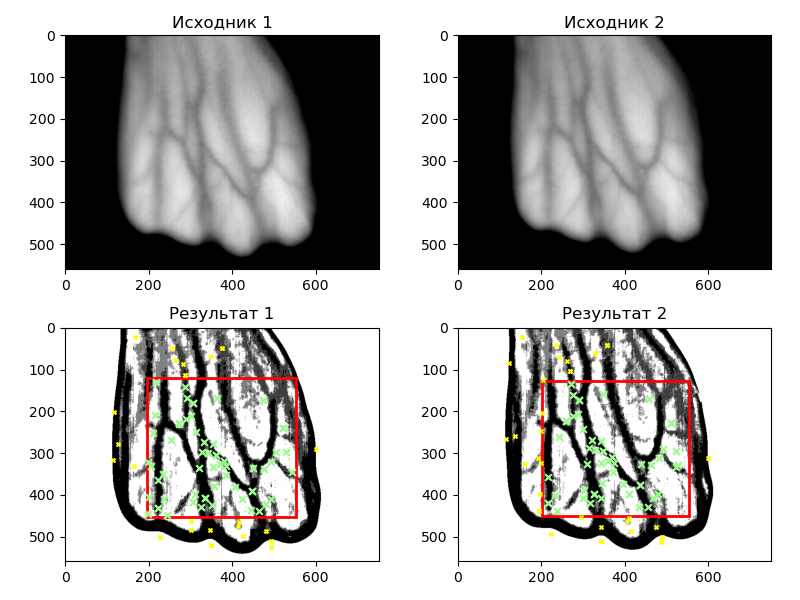

In [6]:
visualize(img1, img2)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [7]:
img1 = cv2.imread(os.path.join('test_221123', '1.jpg'))
img2 = cv2.imread(os.path.join('test_221123', '2.jpg'))

In [8]:
img1 = cv2.rotate(cv2.rotate(img1, cv2.ROTATE_90_CLOCKWISE), cv2.ROTATE_90_CLOCKWISE)
img2 = cv2.rotate(cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE), cv2.ROTATE_90_CLOCKWISE)

In [9]:
Model().identificate(img1, img2) 

(True, 0.9999999999980609)

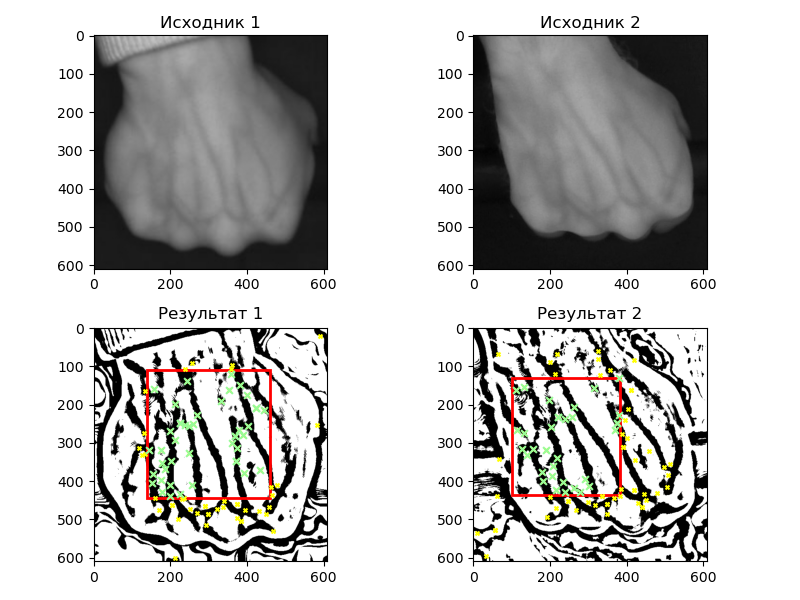

In [10]:
visualize(img1, img2)